## Lets look at the issues brought up in our meeting

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind', n_colors=5576)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
matplotlib.rcParams['font.family'] = 'serif'
import os
import glob
__outdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/Output/'
__datdir__ = os.path.expanduser('~')+'/PhD/Gaia_Project/data/KepxDR2/'

Targets in our dataframe: 100


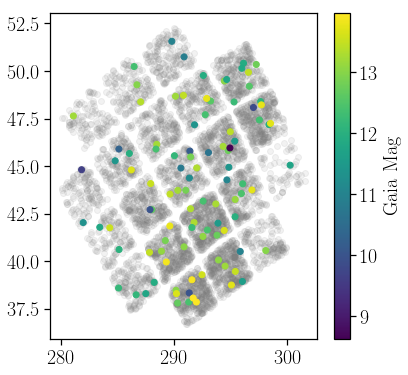

In [2]:
from sklearn.utils import shuffle
kdf = pd.read_csv('/home/oliver/PhD/Gaia_Project/data/KepxDR2/rcxyu18.csv')
nstars = 100
df = shuffle(kdf, random_state=24601).reset_index(drop=True)[:nstars]

print('Targets in our dataframe: '+str(len(df)))
f,a = plt.subplots(figsize=(6,6))
a.scatter(kdf.ra, kdf.dec, c = 'grey', alpha=.1)
c = a.scatter(df.ra, df.dec, c=df.GAIAmag, cmap='viridis')
f.colorbar(c, label=r"Gaia Mag")
plt.show()

## Plot a distribution of average separation for 500 stars

In [3]:
thetaij = np.sqrt(np.subtract.outer(df.ra.values, df.ra.values)**2 + np.subtract.outer(df.dec.values, df.dec.values)**2)

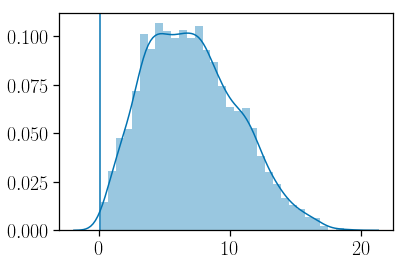

With 100 stars in our dataframe--
Number of separations below 0.125deg : 0


In [4]:
seps = np.tril(thetaij).flatten()
seps = seps[seps > 0.]
sns.distplot(seps)
plt.axvline(0.125)
plt.show()
print('With '+str(nstars)+' stars in our dataframe--')
print('Number of separations below 0.125deg : '+str(len(seps[seps<0.0125])))

## Does the Lindegren equation work as it should?
We can test this by checking whether the equation 
\begin{equation}
\frac{\rm{cov}_{ij}}{\sigma_i,\sigma_j}
\end{equation}
is between $0$ and $1$

In [5]:
def kernel(ra, dec, sigma, p):
    '''
    p[0] : Offset
    p[1] : Exponential decay scale
    '''
    thetaij = np.sqrt(np.subtract.outer(ra, ra)**2 + np.subtract.outer(dec, dec)**2)
    cov = p[0] * np.exp(-thetaij / p[1])
    np.fill_diagonal(cov, np.diag(cov) + sigma**2)
    return cov

In [6]:
p = [285.0*10**-6, 14.]
cov = kernel(kdf.ra.values, kdf.dec.values, kdf.parallax_error.values, p)

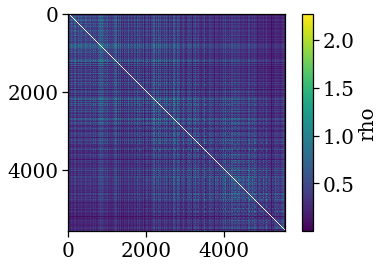

In [7]:
rho = cov / np.outer(kdf.parallax_error.values, kdf.parallax_error.values)
np.fill_diagonal(rho, np.nan)
c = plt.imshow(rho)
plt.colorbar(c, label='rho')
plt.show()

With 31024900 total correlations--
Number of rho values > 1. : 316146


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


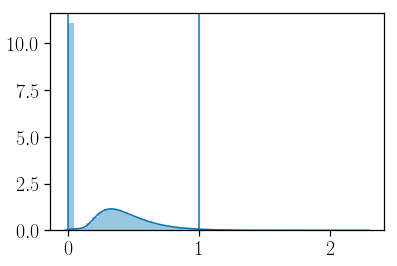

In [8]:
rhos = np.tril(rho).flatten()
sns.distplot(rhos[~np.isnan(rhos)])
plt.axvline(1.)
plt.axvline(0.)
print('With '+str(len(rhos))+' total correlations--')
print('Number of rho values > 1. : '+str(len(rhos[rhos>1.])))

I think this is due to the relation presented in Equation 16 of Lindegren et al. only approximating the true value of the covariance between targets at a given angular separation. The calculated individual covariances would produce correlations between 0 and 1. However, due to the uncertainty on the relation between covariance and angular separation, correlations calculated through this relation will not always fall between 0 and 1. This can be covered by a 1$\mu as$ systematic uncertainty on parallax.

## When run full-field for a scattered sample of 100 stars, what do our parameters look like? Does Q change much?
For this, lets plot violinplots of Q the same way we would $\varpi_{\rm zp}$ for the paper.

In [9]:
def read_music(mls, sig=False):
    chains = np.array([])
    tempscales = np.array([])
    rcmag = np.array([])
    source = np.array([])
    sources = ['Yu+2018','APOKASC-2']
    cols = ['Left','Right']
    col = np.array([])
        
    for idx, ml in enumerate(mls):
        for ts in np.arange(-50.,100.,50.):
            temp = str(ts)

            #Add RC chains & labels
            chain = np.genfromtxt(__outdir__+ml+'/'+'gaia_'+temp+'_chains.txt')[2]
            chains = np.append(chains, chain)
            tempscales = np.append(tempscales, np.ones(len(chain))*ts)
    
            if sig:
                mu = np.round(pd.read_csv(__outdir__+ml+'/'+'gaia_'+temp+'_pars.csv')['sigma'].values[0],2)
            else:
                mu = np.round(pd.read_csv(__outdir__+ml+'/'+'gaia_'+temp+'_pars.csv')['mu'].values[0],2)
            rcmag = np.append(rcmag, np.ones(len(chain))*mu)

            source = np.append(source, [sources[idx]]*len(chain))
            col = np.append(col, [cols[idx]]*len(chain))
                
    music = pd.DataFrame()
    music['chains'] = chains
    music['tempscales'] = tempscales
    music['rcmag'] = rcmag
    music['source'] = source
    music['col'] = col

    return music
def violinplot(mlk, mlg, sigma=False):
    kmusic = read_music(mlk,sigma)
    gmusic = read_music(mlg,sigma)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8), sharey=True)
    sns.violinplot(kmusic.rcmag.values, kmusic.chains.values,
                        palette='Set2', hue = kmusic.source.values, dodge=False, inner='quartile', ax = ax1)
    sns.violinplot(gmusic.rcmag.values, gmusic.chains.values,
                        palette='Set2', hue = gmusic.source.values, dodge=False, inner='quartile', ax = ax2)
    ax1.grid()
    
    ax1.set_axisbelow(True)
    ax2.grid()
    ax2.set_axisbelow(True)  
    
    if sigma:
        ax1.set(xlabel=r'Spread of RC in $K$-band (mag)', ylabel=r'MM Weighting Factor Q')
        ax2.set(xlabel=r'Spread of RC in $G$-band (mag)')
    else:
        ax1.set(xlabel=r'Position of RC in $K$-band (mag)', ylabel=r'MM Weighting Factor Q')
        ax2.set(xlabel=r'Position of RC in $G$-band (mag)')
    ax1.set_title('K band',fontsize=25)
    ax2.set_title(r'$\emph{Gaia}$ G band',fontsize=25)    
    plt.setp(ax1.get_legend().get_texts(), fontsize='25')
    plt.setp(ax2.get_legend().get_texts(), fontsize='25')
    ax1.set_ylim(0.5, 1.)
    ax2.set_ylim(0.5, 1.)
    fig.tight_layout()
    plt.show()

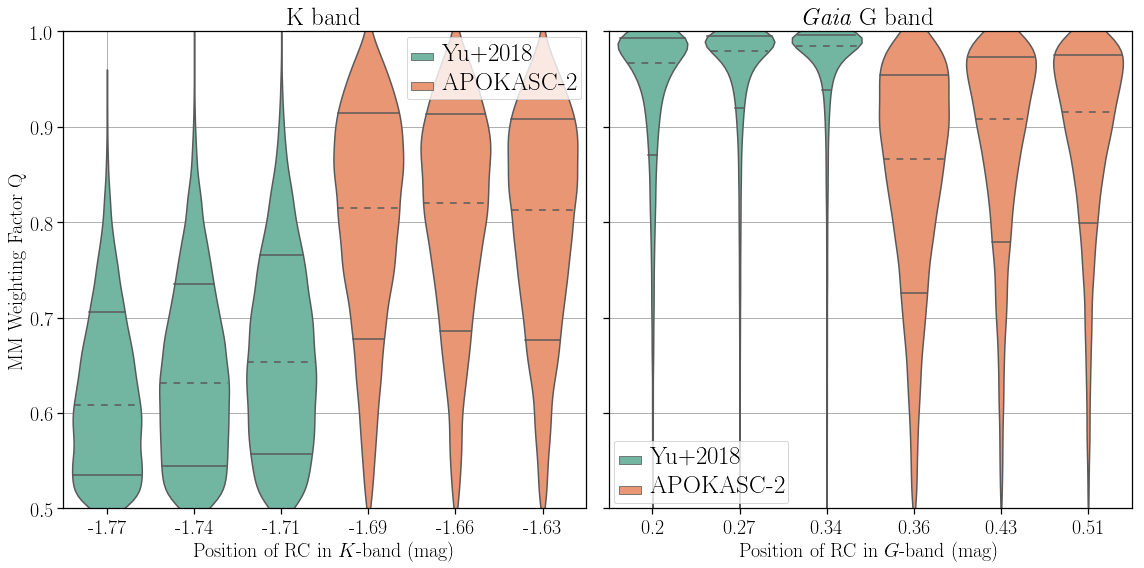

In [10]:
mlk = ['Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
mlg = ['Gaia_GAIA_tempscale_Clump', 'Gaia_APOKASC_GAIA_tempscale_Clump']
violinplot(mlk, mlg)

There are some conflicting results here. For the Yu seismic data we have a lot of outliers. This is likely because the position of the Red Clump for these stars is so improbable that there are many outliers to its distribution. For the APOKASC targets, this is less of an issue.

In the *Gaia* G-band,. all stars are practically inliers for values of the G-band magnitude that are likely wrong using the seismic data. I'm not quite sure why this is--- the input should be the same, the only thing that should change should be the initial guesses and the position of the model. **This is likely due to the inferred spread of the clump changing between the two.**

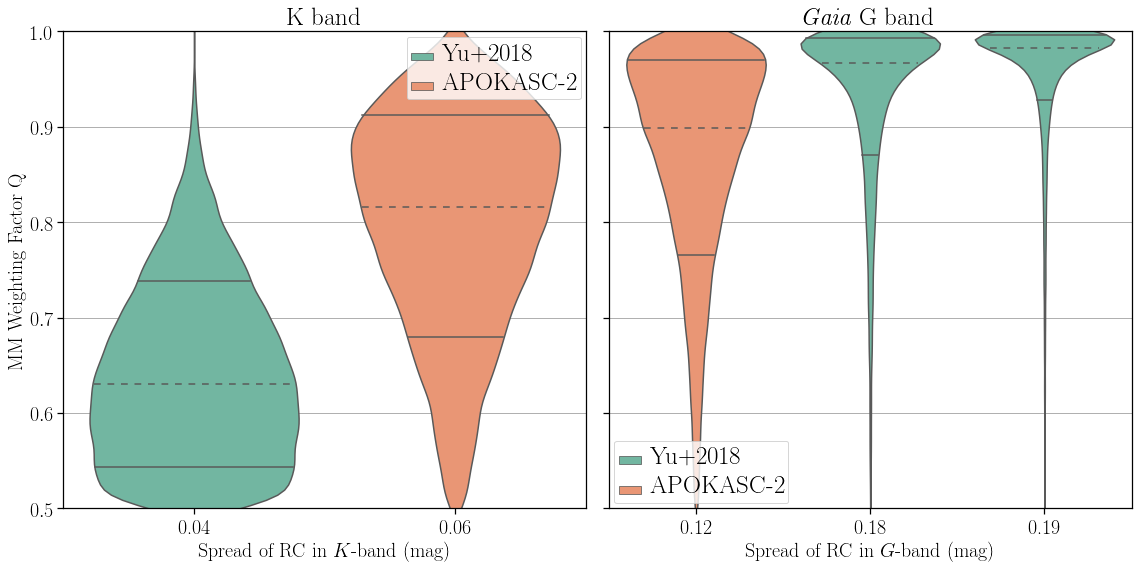

In [11]:
mlk = ['Gaia_K_tempscale_Clump', 'Gaia_APOKASC_K_tempscale_Clump']
mlg = ['Gaia_GAIA_tempscale_Clump', 'Gaia_APOKASC_GAIA_tempscale_Clump']
violinplot(mlk, mlg, sigma=True)

This confirms that suspicion--- with increasing spread of the clump, more stars are included in the inlier population.

## How much can we speed up our run using ADVI?
We'll do a simple run, once with regular Pystan and once with ADVI
Lets take a simple approach first

In [12]:
import pickle
pkl_file = open(__outdir__+'K_tempscale_Clump/astero_0.0_fullchain_dict.pkl', 'rb')
fit = pickle.load(pkl_file)
pkl_file.close()

In [13]:
p = [285.0*10**-6, 14.]
Sigma = kernel(df.ra.values, df.dec.values, df.parallax_error.values, p)
invc = np.linalg.inv(Sigma)
logdetc = np.linalg.slogdet(Sigma)[1] * np.linalg.slogdet(Sigma)[0]

In [14]:
rlebv = df.Aks.values
mband = df.Kmag.values
merr = df.e_Kmag.values
tempdiff = 0.0

dat = {'N':len(df),
       'Nfloat':np.float(len(df)),
        'm': mband,
        'm_err': merr,
        'oo': df.parallax.values,
        'RlEbv': rlebv,
        'logdetc': logdetc,
        'invc': invc,
        'mu_init': np.median(fit['mu'],axis=0),
        'mu_spread': np.std(fit['mu'],axis=0),
        'sig_init': np.median(fit['sigma'],axis=0),
        'sig_spread': np.std(fit['sigma'],axis=0),}

init= {'mu': np.median(fit['mu'],axis=0),
    'sigma': np.median(fit['sigma'],axis=0),
    'Q': np.median(fit['Q'],axis=0),
    'sigo': np.median(fit['sigo'],axis=0),
    'L': 1000.,
    'oo_zp':-29.,
    'r_infd' : df.r_est,
    'Ai' : rlebv}

In [15]:
sm= pickle.load(open('../astrostan.pkl', 'rb'))

In [16]:
reg_fit = sm.sampling(data=dat, iter=5000, chains=4, seed=24601, init=[init for i in range(4)])

In [17]:
vb_fit = sm.vb(data=dat, iter=5000, seed=24601, init=init, output_samples=(5000*4/2))

In [18]:
vbchain = np.array([vb_fit['sampler_params'][i] for i in range(6)])
chain = np.array([reg_fit['mu'],reg_fit['sigma'],reg_fit['Q'],reg_fit['sigo'],reg_fit['L'], reg_fit['oo_zp']])

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.


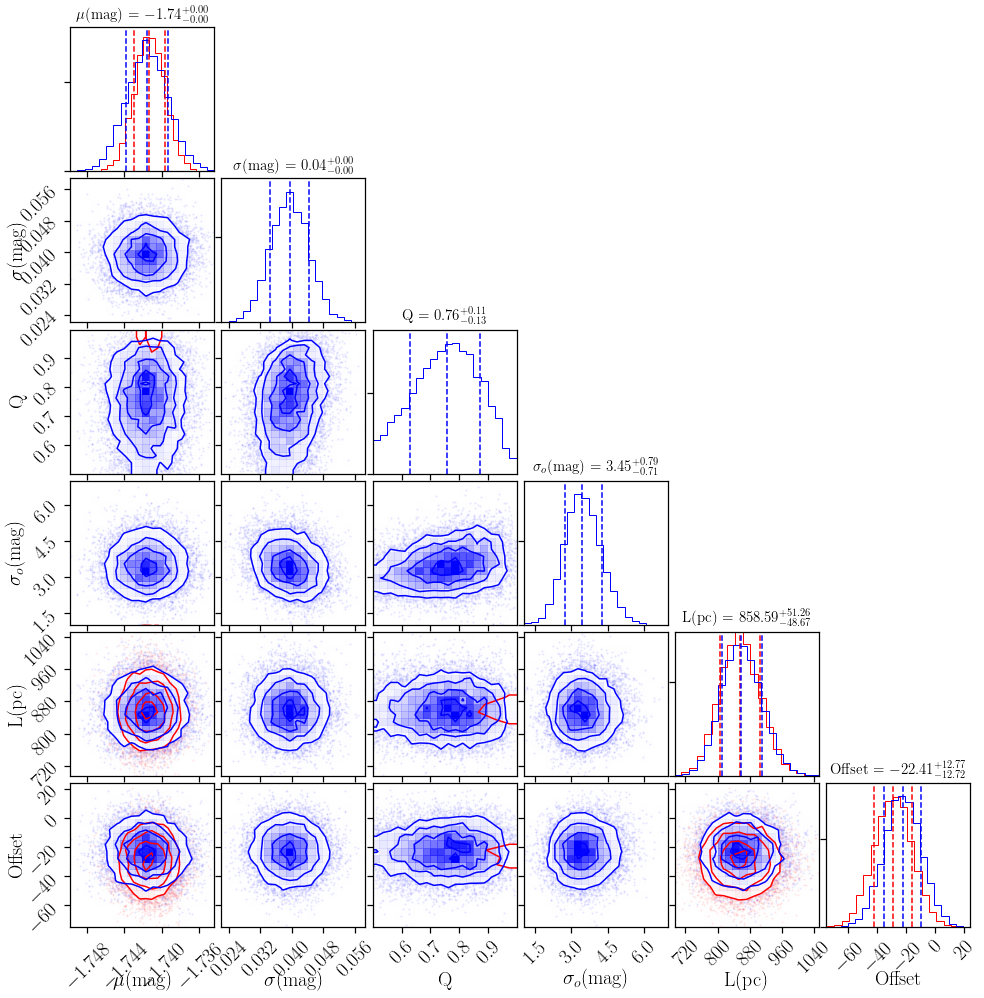

In [27]:
labels=[r'$\mu$(mag)',r'$\sigma$(mag)','Q',r'$\sigma_o$(mag)','L(pc)', 'Offset']
fig = corner.corner(vbchain.T, labels=labels,color='red',  quantiles=[0.16, 0.5, 0.84])
corner.corner(chain.T, fig=fig, color='blue', labels=labels, quantiles=[0.16, 0.5, 0.84],\
                    show_titles=True, title_kwargs={"fontsize": 15} )
plt.show()

### RED: Using ADVI / BLUE: Using regular Pystan sampling



It looks like the ADVI method samples the right regions for some of the key parameters, but falls entirely out of range for others like the spreads and weighting of the inlier/outlier distributions.

Conclusion: We may not want to rely on this method, as it is still experimental in Pystan and not clear how it should be understood.